In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [4]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("./datasets/others")
merge_data = pd.read_csv(data_dir / "merge-date.csv")
merge_data.set_index(
    pd.PeriodIndex(merge_data.date, freq="D"),
    inplace=True,
)

merge_data.drop("date", axis=1, inplace=True)
merge_data.drop("pm2.5", axis=1, inplace=True)
merge_data.drop("no2", axis=1, inplace=True)
merge_data.drop("no", axis=1, inplace=True)
merge_data.drop("so2", axis=1, inplace=True)
merge_data.drop("wd", axis=1, inplace=True)
merge_data.drop("ws", axis=1, inplace=True)
merge_data.drop("blh", axis=1, inplace=True)
merge_data.drop("tcc", axis=1, inplace=True)
merge_data.drop("ssrd", axis=1, inplace=True)
merge_data.drop("pop_tot", axis=1, inplace=True)
merge_data.drop("m00_30", axis=1, inplace=True)
merge_data.drop("m30_60", axis=1, inplace=True)
merge_data.drop("H1_2", axis=1, inplace=True)
merge_data.drop("H2_4", axis=1, inplace=True)
merge_data.drop("H4_8", axis=1, inplace=True)
merge_data.drop("H8_16", axis=1, inplace=True)
merge_data.drop("H16plus", axis=1, inplace=True)

merge_data_per_zip = dict(tuple(merge_data.groupby('PC4')))
merge_data_pc = merge_data_per_zip[5611]
merge_data_pc

,PC4,pm10
date,,
2021-09-25,5611,7.864949
2021-09-25,5611,5.519824
2021-09-25,5611,6.351879
2021-09-25,5611,7.754018
2021-09-25,5611,9.563934
...,...,...
2021-11-18,5611,27.236780
2021-11-18,5611,21.698681
2021-11-18,5611,23.983042


In [6]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = merge_data_pc['pm10'].copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [7]:
# # Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# model = LinearRegression()
# model.fit(X_train, y_train)

# y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
# y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 5.34
Test RMSE: 11.42


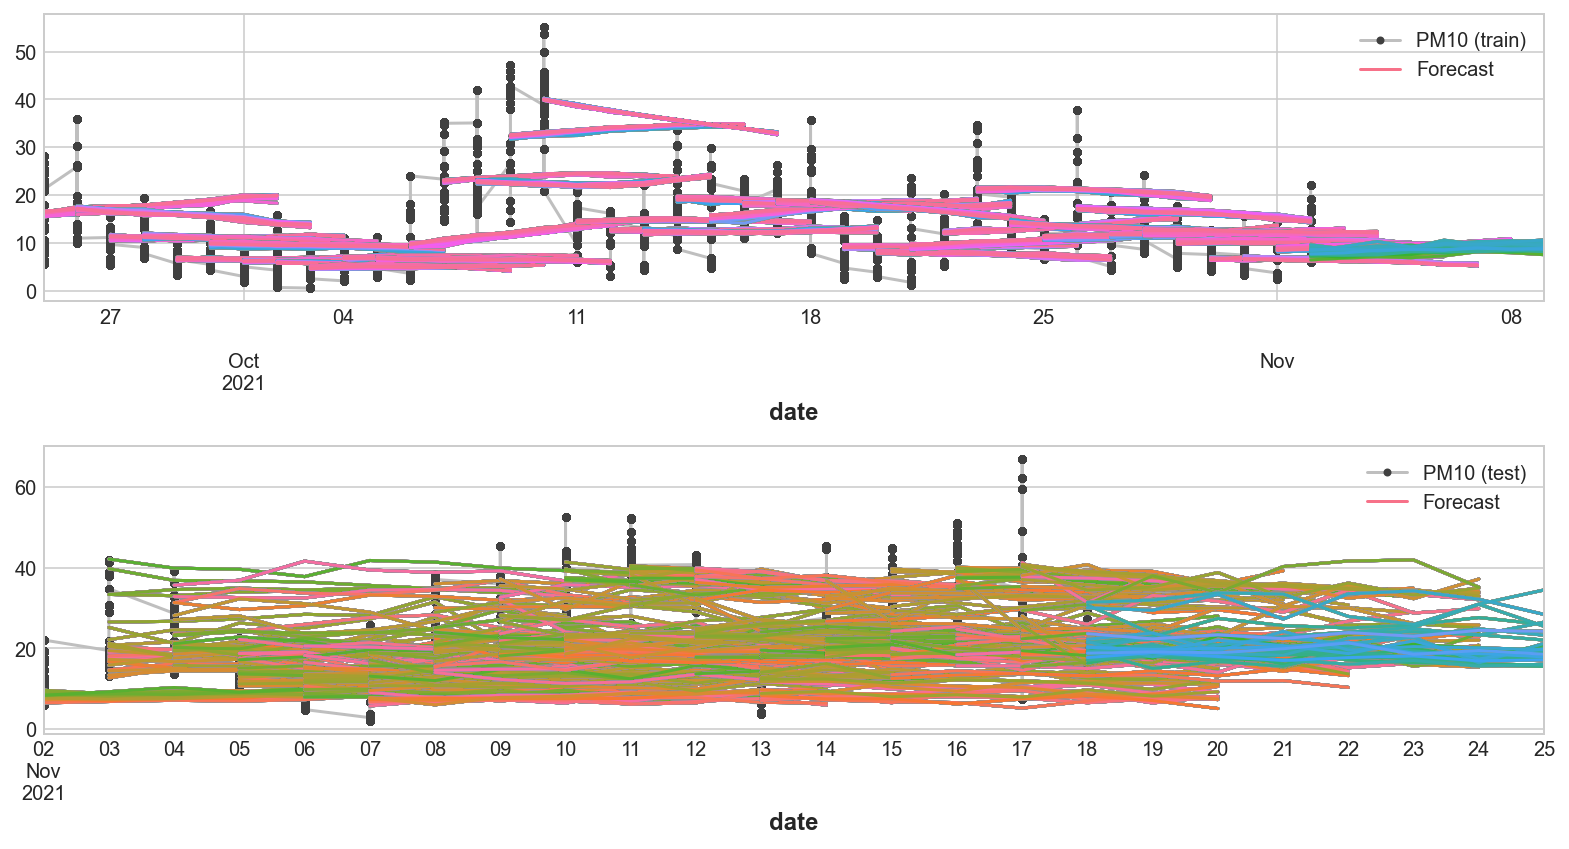

In [9]:

# train_rmse = mean_squared_error(y_train, y_fit, squared=False)
# test_rmse = mean_squared_error(y_test, y_pred, squared=False)
# print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

# palette = dict(palette='husl', n_colors=64)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

# ax1 = merge_data_pc['pm2.5'][y_fit.index].plot(**plot_params, ax=ax1)
# ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
# _ = ax1.legend(['FluVisits (train)', 'Forecast'])

# ax2 = merge_data_pc['pm2.5'][y_pred.index].plot(**plot_params, ax=ax2)
# ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
# _ = ax2.legend(['FluVisits (test)', 'Forecast'])

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = merge_data_pc['pm10'][y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM10 (train)', 'Forecast'])

ax2 = merge_data_pc['pm10'][y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM10 (test)', 'Forecast'])